# Single Slide Processing Pipeline
### Generate ASAP Annotations XML file as result

In [1]:
import numpy as np
from PIL import Image
from utils import *
from ASAPAnnotationXML import *
from ROIUtils import *
from keras.models import Model, load_model
import openslide
from math import ceil
from scipy.ndimage.measurements import label
from scipy.spatial.distance import pdist, squareform
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def RunModelOnTiles(modelfile, slide, tile_list, level=2):
    model = load_model(modelfile)
    batch_size = 64
    steps = ceil((tile_list.shape[0])/batch_size)
    gen = patch_batch_generator(slide, tile_list, batch_size, level=level)
    
    predictions = model.predict_generator(gen, steps, verbose=1)
    
    return predictions

def markImage(slide, tile_list, predictions, return_mask=False, from_level=2, img_level=6, tile_size=256, threshold=0.4, color=[255,0,0]):
    if return_mask:
        img_shape = (slide.level_dimensions[img_level][1], slide.level_dimensions[img_level][0])
        img = np.zeros(img_shape, dtype=np.uint8)
        color = 255
    else:
        img = getRegionFromSlide(slide, level=img_level)
    scale_multiplier = slide.level_downsamples[from_level]/slide.level_downsamples[img_level]
    downsample = slide.level_downsamples[img_level]
    tile = ceil(tile_size * scale_multiplier)
    for i in range(len(tile_list)):
        if predictions[i,1] >= threshold:
            coord = ( int(tile_list[i][0]/downsample) , int(tile_list[i][1]/downsample) )
            img[coord[1]:coord[1]+tile, coord[0]:coord[0]+tile] = color
            #print('marking: ', coord, ' with tile: ', tile)
    return img

def getDetectedMaskList(mask):
    labels, detections = label(mask)
    mask_list = []
    for i in range(1, detections+1):
        m = np.zeros_like(mask)
        m[labels==i] = 255
        mask_list.append(m)
    return mask_list
        
def getBoundaryList(mask):
    mask_list = getDetectedMaskList(mask)
    boundary_list = []
    kernel = np.ones((2,2), dtype=np.uint8)
    for m in mask_list:
        grad = cv2.morphologyEx(m, cv2.MORPH_GRADIENT, kernel)
        boundary_list.append(grad)
    return boundary_list

def getBorderPointsList(mask):
    boundary_list = getBoundaryList(mask)
    borderpoints_list = []
    for b in boundary_list:
        borderpoints_list.append(np.argwhere(b))
    return borderpoints_list

def getAnnotation(borderpoints, coordinate_scale=1, downsample_rate=3):
    pairwise_distance = squareform(pdist(borderpoints))
    max_dist = np.max(pairwise_distance) + 100
    
    for i in range(pairwise_distance.shape[0]):
        pairwise_distance[i,i] = max_dist
    
    seq = [0]
    for i in range(pairwise_distance.shape[0]):
        seq.append(np.argmin(pairwise_distance[seq[-1]]))
        pairwise_distance[seq[-1], seq[-2]] = max_dist
    
    annotation = []
    for s in seq[::downsample_rate]:
        annotation.append((borderpoints[s]*coordinate_scale).astype(np.int64))
        
    return np.array(annotation)
    
def getAnnotationsList(mask, coordinate_scale=1, downsample_rate=3):
    borderpoints_list = getBorderPointsList(mask)
    
    annotation_list = []
    for b in borderpoints_list:
        annotation_list.append(getAnnotation(b, coordinate_scale, downsample_rate))
        
    return annotation_list

In [7]:
## Parameters
level = 0
img_level = 6
pat= '009_node_1'
slide_filename = '../slides/patient_'+pat+'.tif'
xml_append = '../slides/patient_'+pat+'.xml'
xml_out = 'asap_annotation_out/patient_'+pat
modelsaves = 'modelsaves/'
#model_file = '2019-02-15_mobilenetv2_model_camelyon17_imageAug_dropout_afterEpoch-1.h5'
model_file = '2019-03-03_mobilenetv2_model_camelyon17_imageAug_dropout_trainLevel-0-01-01-01_afterEpoch-4.h5'

### Get tile list for slide

In [8]:
slide = getWSI(slide_filename)
tile_list = getPatchCoordListFromFile('', slide_filename, from_level=7)

### Load and run model on tiles and return predictions

In [9]:
predictions = RunModelOnTiles(modelsaves+model_file, getWSI(slide_filename), tile_list, level=level)

2133/2133 [==============================] - 516s 242ms/step


### Preview results on image

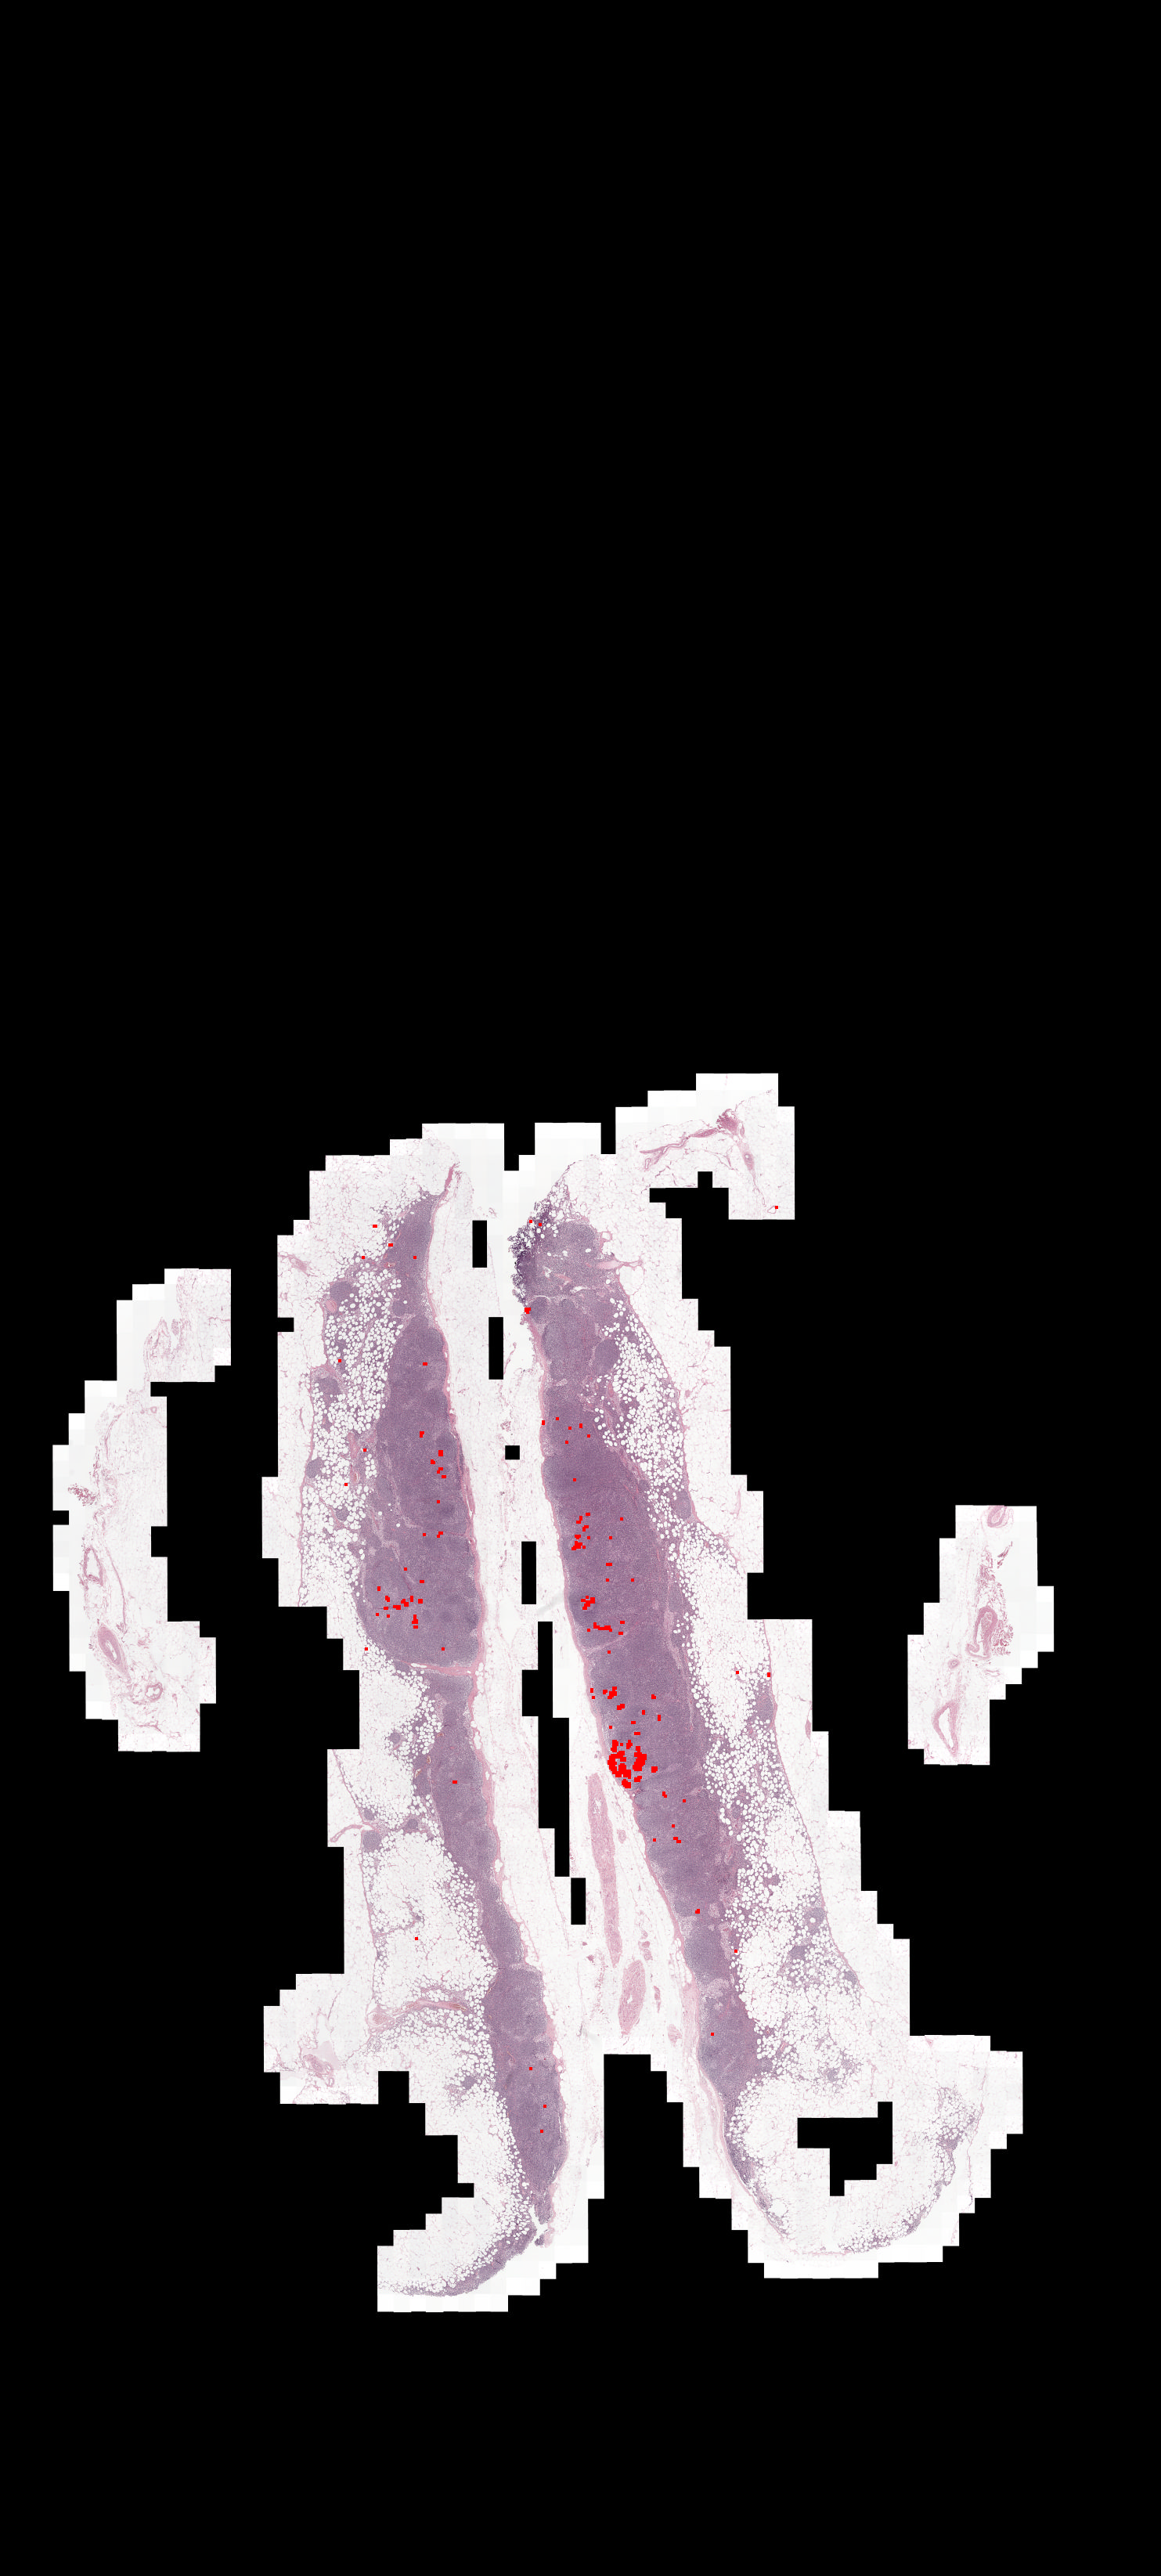

In [10]:
Image.fromarray(markImage(slide, tile_list, predictions, threshold=0.5, from_level=level))

### Get mask, labels and annotation lists

In [44]:
mask = markImage(slide, tile_list, predictions, return_mask=True, threshold=0.5, from_level=level, img_level=img_level)
annotation_list = getAnnotationsList(mask, coordinate_scale=slide.level_downsamples[img_level])

In [45]:
tree = AppendASAP_AnnotationsFile(xml_append, annotation_list, group_color='#00FF00', annotation_color='#00FF00')

In [46]:
tree.write(xml_out+model_file+'.xml')

In [3]:
def multiple_model_annotation_save(model_list, filename_list, xmlname_list, folder, level = 1, img_level = 6, thresh=0.7):
    
    for model_file in model_list:
        for filename, xmlname in zip(filename_list, xmlname_list):
            slide_filename = folder+filename
            xml_append = folder+xmlname
            xml_out = 'asap_annotation_out/'+xmlname
            modelsaves = 'modelsaves/'
            slide = getWSI(slide_filename)
            tile_list = getTileList(slide, level=level)

            print('slide_filename: ', slide_filename)


            predictions = RunModelOnTiles(modelsaves+model_file, slide, tile_list, level=level)
            mask = markImage(slide, tile_list, predictions, return_mask=True, threshold=thresh, from_level=level, img_level=img_level)
            annotation_list = getAnnotationsList(mask, coordinate_scale=slide.level_downsamples[img_level])
            tree = AppendASAP_AnnotationsFile(xml_append, annotation_list, group_color='#00FF00', annotation_color='#00FF00')
            tree.write(xml_out+model_file+'.xml')

In [4]:
model_list = ['2019-03-26_mobilenetv2_model_camelyon17_tsplit_dm075_imageAug_dropout_trainLevel-1_afterEpoch-4.h5',
             '2019-03-22_mobilenetv2_model_camelyon17_tsplit_dm075_imageAug_dropout_trainLevel-1_afterEpoch-2.h5']
filename_list = ['patient_099_node_4.tif', 'patient_087_node_0.tif', 'patient_052_node_1.tif', 'patient_017_node_4.tif']
xmlname_list = ['patient_099_node_4.xml', 'patient_087_node_0.xml', 'patient_052_node_1.xml', 'patient_017_node_4.xml']
folder = '/home/mak/PathAI/slides/'

multiple_model_annotation_save(model_list, filename_list, xmlname_list, folder, thresh=0.7)

slide_filename:  /home/mak/PathAI/slides/patient_099_node_4.tif
603/603 [==============================] - 121s 200ms/step
slide_filename:  /home/mak/PathAI/slides/patient_087_node_0.tif
758/758 [==============================] - 147s 194ms/step
slide_filename:  /home/mak/PathAI/slides/patient_052_node_1.tif
787/787 [==============================] - 181s 230ms/step
slide_filename:  /home/mak/PathAI/slides/patient_017_node_4.tif
1140/1140 [==============================] - 342s 300ms/step
slide_filename:  /home/mak/PathAI/slides/patient_099_node_4.tif
603/603 [==============================] - 125s 207ms/step
slide_filename:  /home/mak/PathAI/slides/patient_087_node_0.tif
758/758 [==============================] - 155s 205ms/step
slide_filename:  /home/mak/PathAI/slides/patient_052_node_1.tif
787/787 [==============================] - 187s 238ms/step
slide_filename:  /home/mak/PathAI/slides/patient_017_node_4.tif
1140/1140 [==============================] - 358s 314ms/step
